In [4]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import itertools
from sklearn.preprocessing import LabelEncoder

In [2]:
test = pd.read_csv('./data/test.csv')
train = pd.read_csv('./data/train.csv')

# 전처리 전

<AxesSubplot:>

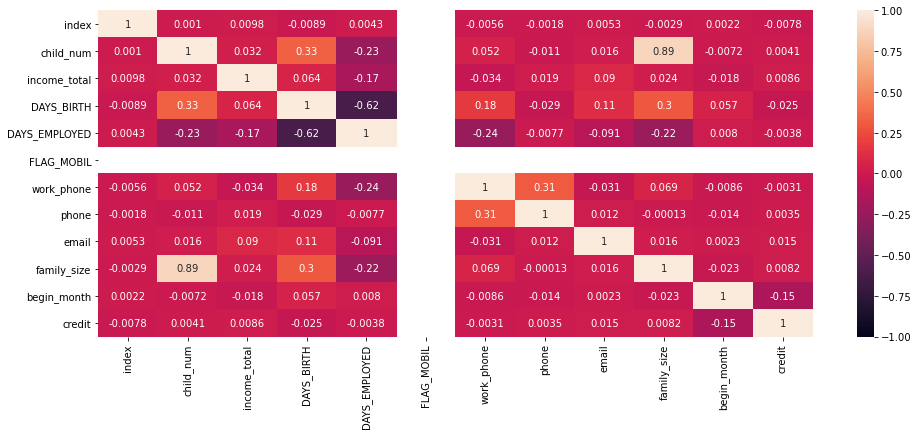

In [3]:
plt.figure(figsize=(16, 6))
sns.heatmap(train.corr(),vmin=-1, vmax=1, annot=True)

# 전처리 후

In [5]:
train.drop(['index', 'FLAG_MOBIL', 'occyp_type'], axis=1, inplace=True)
test.drop(['index', 'FLAG_MOBIL', 'occyp_type'], axis=1, inplace=True)

In [6]:
day_col=['DAYS_BIRTH', 'DAYS_EMPLOYED']
for col in day_col:
    train[col] = train[col].map(lambda x: 0 if x > 0 else x)
    test[col] = test[col].map(lambda x: 0 if x > 0 else x)
    train[col]=np.abs(train[col])/365
    test[col]=np.abs(test[col])/365

train['begin_month']=abs(train['begin_month'])/12
test['begin_month']=abs(test['begin_month'])/12

In [7]:
# child_num, family_size 이상치 존재 -> IQR 이상치 제거 방식
def get_outlier(df=None, column=None, weight=1.5):
    quantile_25 = np.percentile(df[column].values, 25)
    quantile_75 = np.percentile(df[column].values, 75)

    IQR = quantile_75 - quantile_25
    IQR_weight = IQR*weight

    lowest = quantile_25 - IQR_weight
    highest = quantile_75 + IQR_weight

    outlier_idx = df[column][ (df[column] < lowest) | (df[column] > highest) ].index
    return outlier_idx

In [8]:
for df in [train]:
    outlier_idx = get_outlier(df=df, column='child_num', weight=1.5)
    df.drop(outlier_idx, axis=0, inplace=True)
    outlier_idx = get_outlier(df=df, column='family_size', weight=1.5)
    df.drop(outlier_idx, axis=0, inplace=True)

<AxesSubplot:>

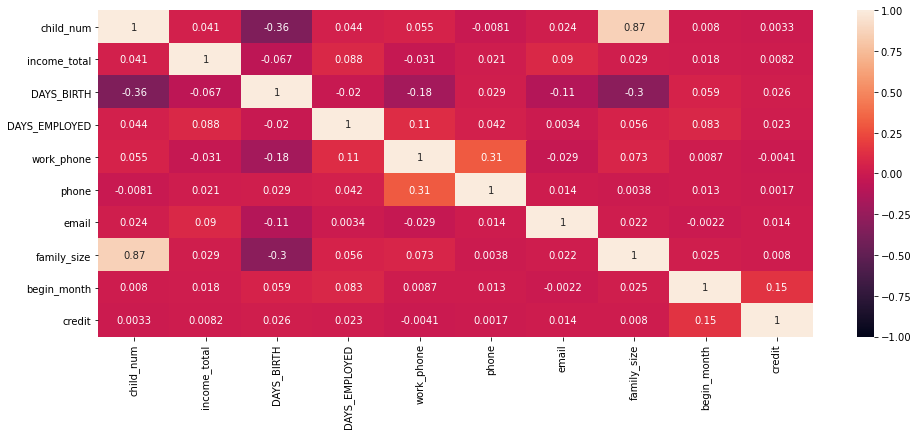

In [9]:
plt.figure(figsize=(16, 6))
sns.heatmap(train.corr(),vmin=-1, vmax=1, annot=True)

# 파생변수 후

In [10]:
train['hardship']=((train['DAYS_BIRTH']-40)**3)*train['child_num']
test['hardship']=((test['DAYS_BIRTH']-40)**3)*test['child_num']

In [11]:
train['communication']=0
test['communication']=0
for col in ['phone','work_phone','email']:
    train['communication']+=train[col]
    train=train.drop(col,axis=1)
for col in ['phone','work_phone','email']:
    test['communication']+=test[col]
    test=test.drop(col,axis=1)

In [12]:
train['before_EMPLOYED'] = train['DAYS_BIRTH'] - train['DAYS_EMPLOYED']
test['before_EMPLOYED'] = test['DAYS_BIRTH'] - test['DAYS_EMPLOYED']

In [13]:
train['ability'] = train['income_total'] / (train['DAYS_BIRTH'] + train['DAYS_EMPLOYED'])
test['ability'] = test['income_total'] / (test['DAYS_BIRTH'] + test['DAYS_EMPLOYED'])

In [14]:
train['income_mean'] = train['income_total'] / train['family_size']
test['income_mean'] = test['income_total'] / test['family_size']

In [15]:
train['adult_num'] = train['family_size'] - train['child_num']
test['adult_num'] = test['family_size'] - test['child_num']

In [16]:
train = train[(train['adult_num'] > 0)]
train = train.reset_index(drop = True)

<AxesSubplot:>

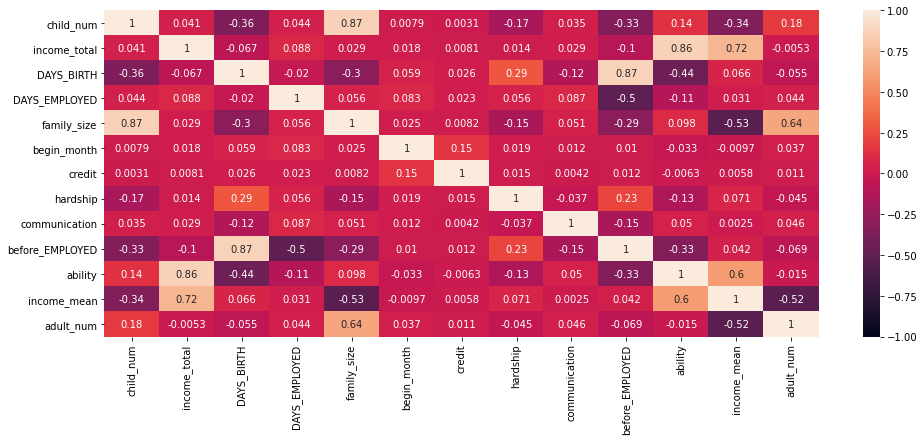

In [17]:
plt.figure(figsize=(16, 6))
sns.heatmap(train.corr(),vmin=-1, vmax=1, annot=True)

# 이진변수 수치화

In [18]:
train['gender'] = train['gender'].replace(['F','M'],[0,1])
test['gender'] = test['gender'].replace(['F','M'],[0,1])
print('gender :')
print(train['gender'].value_counts())
print('--------------')

print('Having a car or not : ')
train['car'] = train['car'].replace(['N','Y'],[0,1])
test['car'] = test['car'].replace(['N','Y'],[0,1])
print(train['car'].value_counts())
print('--------------')

print('Having house reality or not: ')
train['reality'] = train['reality'].replace(['N','Y'],[0,1])
test['reality'] = test['reality'].replace(['N','Y'],[0,1])
print(train['reality'].value_counts())

gender :
0    17465
1     8617
Name: gender, dtype: int64
--------------
Having a car or not : 
0    16221
1     9861
Name: car, dtype: int64
--------------
Having house reality or not: 
1    17552
0     8530
Name: reality, dtype: int64


In [19]:
categorical_feats = ['income_type', 'family_type', 'house_type']
enc = LabelEncoder()
for i in categorical_feats:
    enc.fit(train[i])
    train[i] = enc.transform(train[i])
    test[i] = enc.transform(test[i])

In [20]:
def edu_transform(data):
    edu_ = ['Lower secondary','Secondary / secondary special',
            'Incomplete higher','Higher education','Academic degree']
    if data == edu_[0]:
        return 0
    elif data == edu_[1]:
        return 1
    elif data == edu_[2]:
        return 2
    elif data == edu_[3]:
        return 3
    else: 
        return 4

In [21]:
def edu_inverse(data):
    edu_ = ['Lower secondary','Secondary / secondary special',
            'Incomplete higher','Higher education','Academic degree']
    if data == 0:
        return edu_[0]
    elif data == 1:
        return edu_[1]
    elif data == 2:
        return edu_[2]
    elif data == 3:
        return edu_[3]
    else: 
        return edu_[4]

In [22]:
train['edu_type'] = train['edu_type'].apply(edu_transform)
test['edu_type'] = test['edu_type'].apply(edu_transform)

In [23]:
for df in [train,test]:
    df['income_total'] = np.log1p(1+df['income_total'])

<AxesSubplot:>

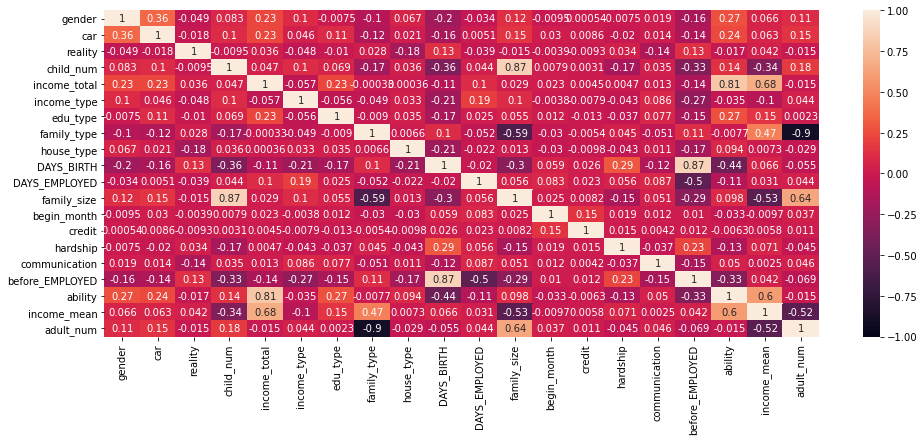

In [24]:
plt.figure(figsize=(16, 6))
sns.heatmap(train.corr(),vmin=-1, vmax=1, annot=True)